In [1]:
### Initialize & Read in data ###

from pylab import *
import numpy as np
import scipy as sp
import time
import os

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import LineCollection
%matplotlib inline 
# Normal matplotlib => just wrap in $ for latex

#import mpld3 # This is a widget for zooming in and manipulating plots
#mpld3.enable_notebook()

from sklearn import gaussian_process

In [2]:
### 27912 tracks numbers, 27891 total tracks ###
### Cut matrix: 1000 track numbersm 992 total tracks ###
### Create data matrix ###

dir_path = '../Data/npy_resampled_cut/'

### Read in the inputs for each track ###
inputs = []
outputs_1 = []
outputs_2 = []

for file in os.listdir(dir_path):
    x = np.load(dir_path + file)
    
    inputs.append([[float(x['Mbh_init'])],[float(x['M2_init'])],[float(x['P_init'])]])
        
    outputs_1.append(x['xr1'])
    outputs_2.append(x['xr2'])
        
    # Could also try to run GP for each timestep separately
        
inputs = np.reshape(inputs,[len(inputs),3])

In [3]:
shape(inputs)

(297, 3)

The initial conditions for track 226 are: Mbh = 4.000000, M2 = 1.093932, & P = 3.026561


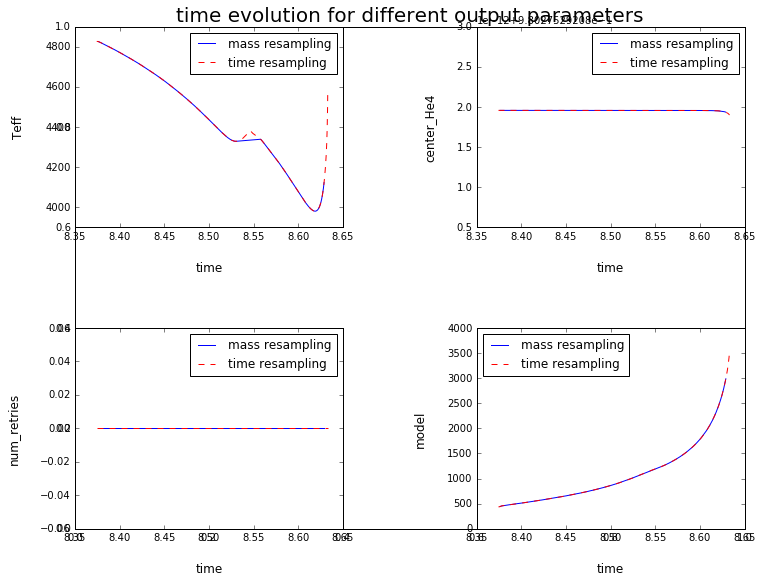

In [115]:
'''Run some time evolution tracks for both resampling'''

### Set up plots ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)
plt.title('time evolution for different output parameters', size=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs=[ax1,ax2,ax3,ax4]

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

#plt.xlabel('time (Gyr)', labelpad=20, size=15)
#plt.ylabel('logT', rotation=90, labelpad=20, size=15)

### POSSIBLE OUTPUTS TO PLOT ###
'''
(0'log_dt', 1'he_core_mass', 2'LH', 3'LHe', 4'Teff', 5'L', 
 6'R', 7'logg', 8'center_H1', 9'center_He4', 10'num_retries', 
 11'model', 12'age', 13'P', 14'A', 15'rl_relative_overflow', 16'M2', 
 17'Mbh', 18'log_abs_mdot', 19'xfer_fraction')
 '''
age_index = 12
timesteps = np.linspace(0,999,1000)

### Choose the track number you want to look at ###
track = 226
print 'The initial conditions for track %i are: Mbh = %f, M2 = %f, & P = %f' % (track,inputs[track,0],inputs[track,1],inputs[track,2])
    
### Choose 4 outputs to plot time evolution ###
evo=[4,9,10,11]    

### For labeling, reference a sample path ###
sample_path = '../Data/npy_resampled/file1.npz'
x = np.load(sample_path)


for i in xrange(len(axs)):
    
    # Set up subplot
    ax = axs[i]
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('time', rotation=0, labelpad=20, size=12)
    ax.set_ylabel(x['xr1'].dtype.names[evo[i]], rotation=90, labelpad=20, size=12)
    ax.legend([lc1, lc2], ['mass resampling', 'time resampling'], loc=0)
    
    # Pick out interpolation for each correlation and plot
    resample_1=[]
    resample_2=[]
    time_1=[]
    time_2=[]
    for j in xrange(1000):
        resample_1.append(outputs_1[track][j][evo[i]])
        resample_2.append(outputs_2[track][j][evo[i]])
        time_1.append((outputs_1[track][j][age_index])/10**9)
        time_2.append((outputs_2[track][j][age_index])/10**9)
    ax.plot(time_1, resample_1, 'b-')
    ax.plot(time_2, resample_2, 'r--')
    
plt.show()


In [15]:
'''Convert list into matrix of shape (track,parameter,timestep)'''
matrix_1= np.zeros((len(outputs_1),1000,20))
matrix_2 = np.zeros((len(outputs_1),1000,20))
data_1 = np.array(outputs_1)
data_2 = np.array(outputs_2)

print len(outputs_1)

for i in xrange(len(outputs_1)):
    for j in xrange(1000):
        for k in xrange(20):
            matrix_1[i,j,k]=data_1[i,j][k]
            matrix_2[i,j,k]=data_2[i,j][k]
            
matrix_1 = np.swapaxes(matrix_1,1,2)
matrix_2 = np.swapaxes(matrix_2,1,2)

print shape(matrix_1),shape(matrix_2)

297
(297, 20, 1000) (297, 20, 1000)


In [60]:
#Delete the columns we don't care about
outputs1 = np.delete(matrix_1,(0,10,11),1)
outputs2 = np.delete(matrix_2,(0,10,11),1)

In [97]:
'''Pick random IC to leave out, interpolate over this and compare with actual'''
q=randint(0,len(inputs))
temp = list(inputs)
random_IC = array(temp.pop(q))
temp = array(temp)

temp_out_1 = list(outputs1)
temp_out_2 = list(outputs2)
temp_out_1.pop(q)
temp_out_2.pop(q)
temp_out_1 = array(temp_out_1)
temp_out_2 = array(temp_out_2)

print "The randomly-selected track is %i with initial conditions Mbh = %f, M2 = %f, & P = %f" % (q,random_IC[0],random_IC[1],random_IC[2])



The randomly-selected track is 226 with initial conditions Mbh = 4.000000, M2 = 1.093932, & P = 3.026561


In [98]:
'''Run GP on the remaining dataset'''

def GP(x, y):
    gp = gaussian_process.GaussianProcess(corr='absolute_exponential', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,nugget=2e-5)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    gp.fit(x, y)
    
    x_pred = np.atleast_2d(random_IC)
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Run GP for each timestep, not including the one left out ###

# Run for the first resampling
x_pred_1=[]; y_pred_1=[]; sigma_1=[]
start_time = time.time()
for i in xrange(0,1000):
    x_GP, y_GP, sigma_GP = GP(temp,temp_out_1[:,:,i])
    x_pred_1.append(x_GP)
    y_pred_1.append(y_GP)
    sigma_1.append(sigma_GP)
    
    if i%50==0:
        print i

elapsed = time.time() - start_time # See how long it took
print 'It only took %f seconds!' % (elapsed)


# Run for the second resampling
start_time = time.time()
x_pred_2=[]; y_pred_2=[]; sigma_2=[]
for i in xrange(0,1000):
    x_GP, y_GP, sigma_GP = GP(temp,temp_out_2[:,:,i])
    x_pred_2.append(x_GP)
    y_pred_2.append(y_GP)
    sigma_2.append(sigma_GP)
    
    if i%50==0:
        print i

elapsed = time.time() - start_time # See how long it took
print 'It only took %f seconds!' % (elapsed)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
It only took 130.243018 seconds!
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
It only took 136.259696 seconds!


In [68]:
interp_1[:,evo]

array([[  8.31113978e-01,   4.53600093e+09,   3.66084660e-01,
          1.03772211e+01],
       [  8.20045826e-01,   4.45342252e+09,   3.84950729e-01,
          9.68472623e+00],
       [  8.16023449e-01,   4.42225348e+09,   3.98050319e-01,
          9.48344102e+00],
       ..., 
       [  7.06670268e-01,   7.08624043e+09,   8.11778176e+01,
          1.84273163e+02],
       [  7.06670268e-01,   7.08624043e+09,   8.11778176e+01,
          1.84273163e+02],
       [  7.06670268e-01,   7.08624043e+09,   8.11778176e+01,
          1.84273163e+02]])

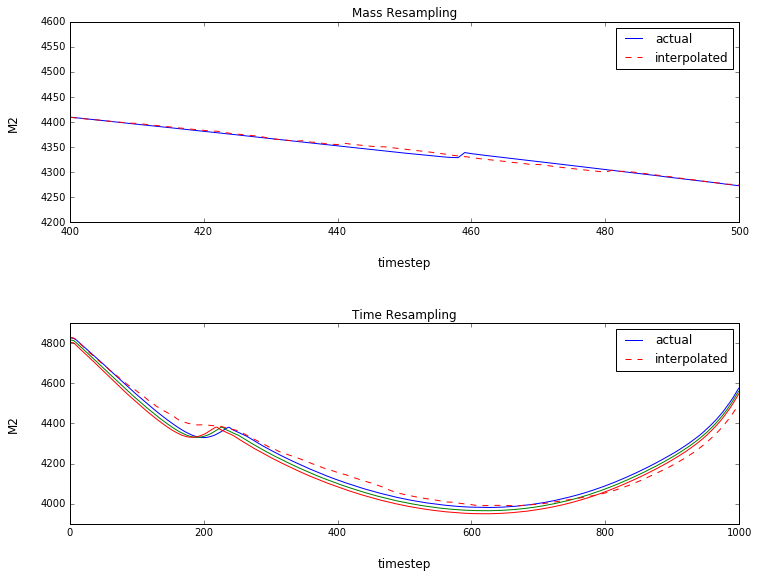

In [119]:
# '''Plot evolution tracks for actual and interpolated'''

actual_1 = matrix_1[q]
actual_2 = matrix_2[q]
actual_3 = matrix_2[q+1]
actual_4 = matrix_2[q+2]
interp_1 = np.reshape(y_pred_1,(1000,17))
interp_2 = np.reshape(y_pred_2,(1000,17))

parameters=['log_dt', 'he_core_mass', 'LH', 'LHe', 'Teff', 'L', 
    'R', 'logg', 'center_H1', 'center_He4', 'num_retries', 
    'model', 'age', 'P', 'A', 'rl_relative_overflow', 'M2', 
    'Mbh', 'log_abs_mdot', 'xfer_fraction']

### Set up plots ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

# Set parameter to plot, and make timesteps
param_num = 16
timesteps = np.linspace(0,999,1000)

ax1.set_xlim(400,500)
ax1.set_ylim(4200,4600)
ax1.set_xlabel('timestep', rotation=0, labelpad=20, size=12)
ax1.set_ylabel(parameters[param_num], rotation=90, labelpad=20, size=12)
ax1.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
ax1.set_title("Mass Resampling")
ax1.plot(timesteps, actual_1[4], 'b-')
ax1.plot(timesteps, interp_1[:,3], 'r--')

ax2.set_xlabel('timestep', rotation=0, labelpad=20, size=12)
ax2.set_ylabel(parameters[param_num], rotation=90, labelpad=20, size=12)
ax2.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
ax2.set_title("Time Resampling")
ax2.plot(timesteps, actual_2[4], 'b-')
ax2.plot(timesteps, actual_3[4], 'g-')
ax2.plot(timesteps, actual_4[4], 'r-')
ax2.plot(timesteps, interp_2[:,3], 'r--')
